In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! git clone https://github.com/spMohanty/PlantVillage-Dataset


Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 16.89 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.


In [3]:
#importing necessary libraries and APIs

import warnings
warnings.filterwarnings("ignore")
import os
import glob
import matplotlib.pyplot as plt
import keras

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#data path

data_dir = "/content/PlantVillage-Dataset/raw/segmented"


In [5]:
#function that counts the number of files in a dierctory
def get_files(dir):
  if not os.path.exists(dir):
    return 0
  c=0 #initialize count with zero
  for curr_path,dirs,files in os.walk(dir):
    for d in dirs:
      c+= len(glob.glob(os.path.join(curr_path,d+"/*")))

  return c

In [6]:
segmented_data=get_files(data_dir)
num_classes=len(glob.glob(data_dir+"/*"))
print(num_classes,"Classes")


38 Classes


In [7]:
pip install split-folders


In [8]:
import splitfolders 
splitfolders.ratio("/content/PlantVillage-Dataset/raw/segmented", output="train_test", seed=1337, ratio=(.8, .2), group_prefix=None) # default values


Copying files: 54306 files [00:07, 7259.90 files/s]


In [9]:
train_dir ="/content/train_test/train"
test_dir="/content/train_test/val"


In [10]:
#data generator to generate images 

train_datagen=ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, validation_split=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [11]:
img_width,img_height =224,224 #sizes are compatible with MobileNet
input_shape=(img_width,img_height,3)
batch_size =64
train_generator =train_datagen.flow_from_directory(train_dir,shuffle=True, #added shuffle here
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size,
                                                   subset='training')
validation_generator =train_datagen.flow_from_directory(train_dir,shuffle=True, #added shuffle here
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size,
                                                   subset='validation')
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 34757 images belonging to 38 classes.
Found 8673 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.


In [12]:

IMG_SHAPE = (img_width, img_height, 3)

# base model is the pre-trained model MobileNet V2 (from keras library)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
#Adding the layers (model 1)

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='elu'),
  tf.keras.layers.Dropout(0.5),  #increase dropout
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(38, activation='softmax')
])

In [15]:
base_model.trainable = True


In [16]:
print("The number of layers in base model: ", len(base_model.layers))
fine_tune_at = 100 #training the last 55
for layer in base_model.layers[:fine_tune_at]: # freezing the layers till the point we specified
  layer.trainable =  False

Number of layers in the base model:  155


In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 38)                1254      
Total params: 2,627,910
Trainable params: 2,232,518
Non-trainable params: 395,392
_________________________________________________________________


In [19]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))


Number of trainable variables = 60


In [20]:
history_fine = model.fit_generator(train_generator, 
                         epochs=10,
                         validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
544/544 [==============================] - 441s 811ms/step - loss: 1.7208 - accuracy: 0.5747 - val_loss: 1.5478 - val_accuracy: 0.5742
Epoch 2/10
544/544 [==============================] - 441s 811ms/step - loss: 0.6128 - accuracy: 0.8406 - val_loss: 0.7787 - val_accuracy: 0.7884
Epoch 3/10
544/544 [==============================] - 441s 810ms/step - loss: 0.3806 - accuracy: 0.8963 - val_loss: 0.4168 - val_accuracy: 0.8852
Epoch 4/10
544/544 [==============================] - 439s 807ms/step - loss: 0.2772 - accuracy: 0.9225 - val_loss: 0.2773 - val_accuracy: 0.9203
Epoch 5/10
544/544 [==============================] - 437s 804ms/step - loss: 0.2195 - accuracy: 0.9372 - val_loss: 0.2020 - val_accuracy: 0.9399
Epoch 6/10
544/544 [==============================] - 436s 801ms/step - loss: 0.1776 - accuracy: 0.9474 - val_loss: 0.1572 - val_accuracy: 0.9503
Epoch 7/10
544/544 [============================

In [23]:
score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

170/170 [==============================] - 20s 120ms/step - loss: 0.1090 - accuracy: 0.9654
Test loss: 0.1089906096458435
Test accuracy: 0.9654284715652466


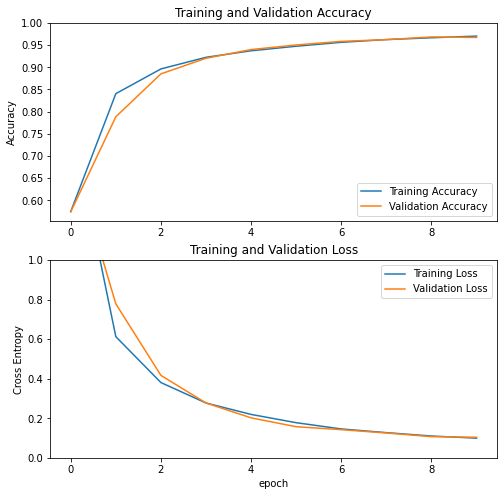

In [24]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()